# Markov Switching Model Notebook

This notebook downloads a stock return series, tests for stationarity, and fits a Markov Switching AR(1) model (two regimes). It then analyzes the estimated regimes via smoothed probabilities.

**Sections:**
1. Install Requirements  
2. Imports  
3. Data Download & Preparation  
4. Stationarity Test  
5. Fit Markov Switching Model  
6. Regime Analysis & Plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import yfinance as yf

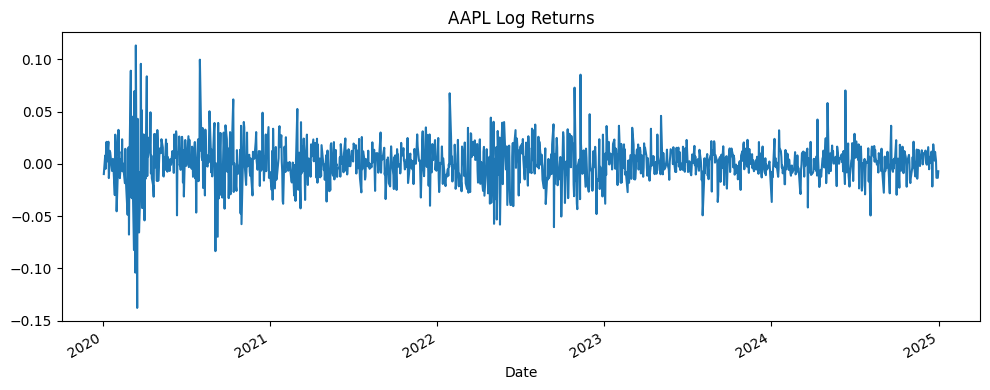

In [2]:
# Download daily close prices for AAPL
ticker = 'AAPL'
hist = yf.Ticker(ticker).history(start='2020-01-01', end='2025-01-01')
data = hist['Close'].dropna()

# Compute log returns
returns = np.log(data).diff().dropna()

# Quick view
returns.plot(title=f'{ticker} Log Returns', figsize=(10,4))
plt.tight_layout()
plt.show()

In [3]:
# Augmented Dickey-Fuller test on returns
def adf_test(series, title=''):
    print(f'--- ADF Test: {title} ---')
    res = adfuller(series)
    out = pd.Series(res[:4], index=['Test Statistic','p-value','# Lags','Observations'])
    for k, v in res[4].items():
        out[f'Crit. Value ({k})'] = v
    print(out.to_string(), '\n')

adf_test(returns, title=f'{ticker} Log Returns')

--- ADF Test: AAPL Log Returns ---
Test Statistic      -1.128438e+01
p-value              1.430055e-20
# Lags               8.000000e+00
Observations         1.248000e+03
Crit. Value (1%)    -3.435601e+00
Crit. Value (5%)    -2.863859e+00
Crit. Value (10%)   -2.568004e+00 



In [4]:
# Fit a two-regime Markov Switching AR(1) model on returns
model = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True, order=1)
ms_res = model.fit(em_iter=10, search_reps=20, disp=False)
print(ms_res.summary())

/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  Close   No. Observations:                 1257
Model:               MarkovRegression   Log Likelihood                3282.041
Date:                Sun, 03 Aug 2025   AIC                          -6552.082
Time:                        02:41:45   BIC                          -6521.264
Sample:                             0   HQIC                         -6540.500
                               - 1257                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.169      0.866      -0.004       0.004
sigma2         0.0011      0.000      7.920      0.0

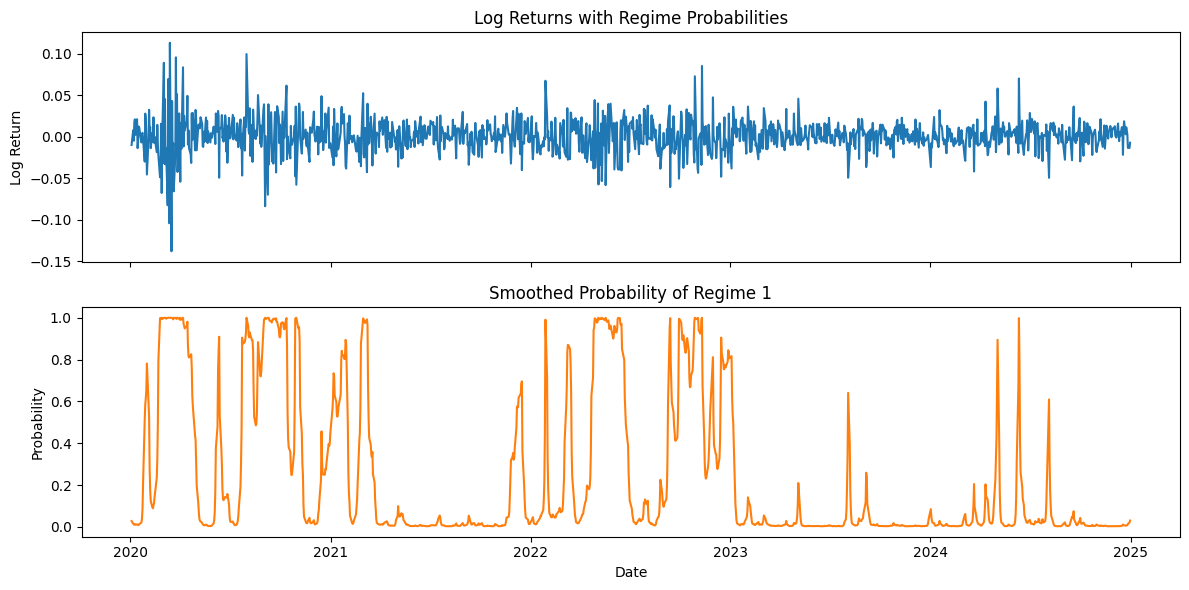

In [5]:
# Plot smoothed probabilities of Regime 1
smoothed = ms_res.smoothed_marginal_probabilities[0]
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

# Returns series
ax[0].plot(returns.index, returns, label='Returns')
ax[0].set(title='Log Returns with Regime Probabilities', ylabel='Log Return')

# Smoothed probability
ax[1].plot(smoothed.index, smoothed, label='Pr(Regime 1)', color='tab:orange')
ax[1].set(title='Smoothed Probability of Regime 1', ylabel='Probability', xlabel='Date')

plt.tight_layout()
plt.show()

In [9]:
# Extract regime means from the fitted params
params = ms_res.params

# The names in your printout are 'const[0]' and 'const[1]'
mu0 = params['const[0]']
mu1 = params['const[1]']

print(f'Regime 0 mean (const[0]): {mu0:.6f}')
print(f'Regime 1 mean (const[1]): {mu1:.6f}')

Regime 0 mean (const[0]): -0.000333
Regime 1 mean (const[1]): 0.001405
